In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc
import tensorflow as tf
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True'
import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')


2022-10-17 11:08:11.866212: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Global seed set to 0


In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2022-10-17 11:08:18.945564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


True

2022-10-17 11:08:18.949325: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-17 11:08:19.062305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-17 11:08:19.144594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Quadro M2000 computeCapability: 5.2
coreClock: 1.1625GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 98.44GiB/s
2022-10-17 11:08:19.144672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-17 11:08:19.148826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-17 11:08:19.148921: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-10-17

In [3]:
tf.test.is_gpu_available()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-10-17 11:08:19.754840: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-17 11:08:19.755109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: Quadro M2000 computeCapability: 5.2
coreClock: 1.1625GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 98.44GiB/s
2022-10-17 11:08:19.755183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-17 11:08:19.755226: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-17 11:08:19.755254: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-10-17 11:08:19.755281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2022-10-

In [4]:
# Set paths to data and results used through the document:
sp_data_folder = '/media/alina/Backup1/Cell2LocationNew/data/brain_visium_wo_cloupe_data/'
results_folder = '/media/alina/Backup1/Cell2LocationNew/results/mouse_brain_snrna/'

results_folder = '/media/alina/Backup1/Cell2LocationNew/data/mouse_brain_visium_wo_cloupe_data/rawdata/V216-FUS-3xTg-AK/filtered_feature_bc_matrix.h5'



regression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

In [6]:
def read_and_qc(sample_name, path=sp_data_folder + 'rawdata/'):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

#######################
# Read the list of spatial experiments
sample_data = pd.read_csv('/media/alina/Backup1/Cell2LocationNew/data/mouse_brain_visium_wo_cloupe_data/Visium_mouse.csv')

# Read the data into anndata objects
slides = []
for i in sample_data['sample_name']:
    slides.append(read_and_qc(i, path="/media/alina/Backup1/Cell2LocationNew/data/mouse_brain_visium_wo_cloupe_data/rawdata/"))

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_data['sample_name'],
    index_unique=None
)
#######################

In [7]:
# mitochondria-encoded (MT) genes should be removed for spatial mapping
adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
adata = adata[:, ~adata.var['mt'].values]

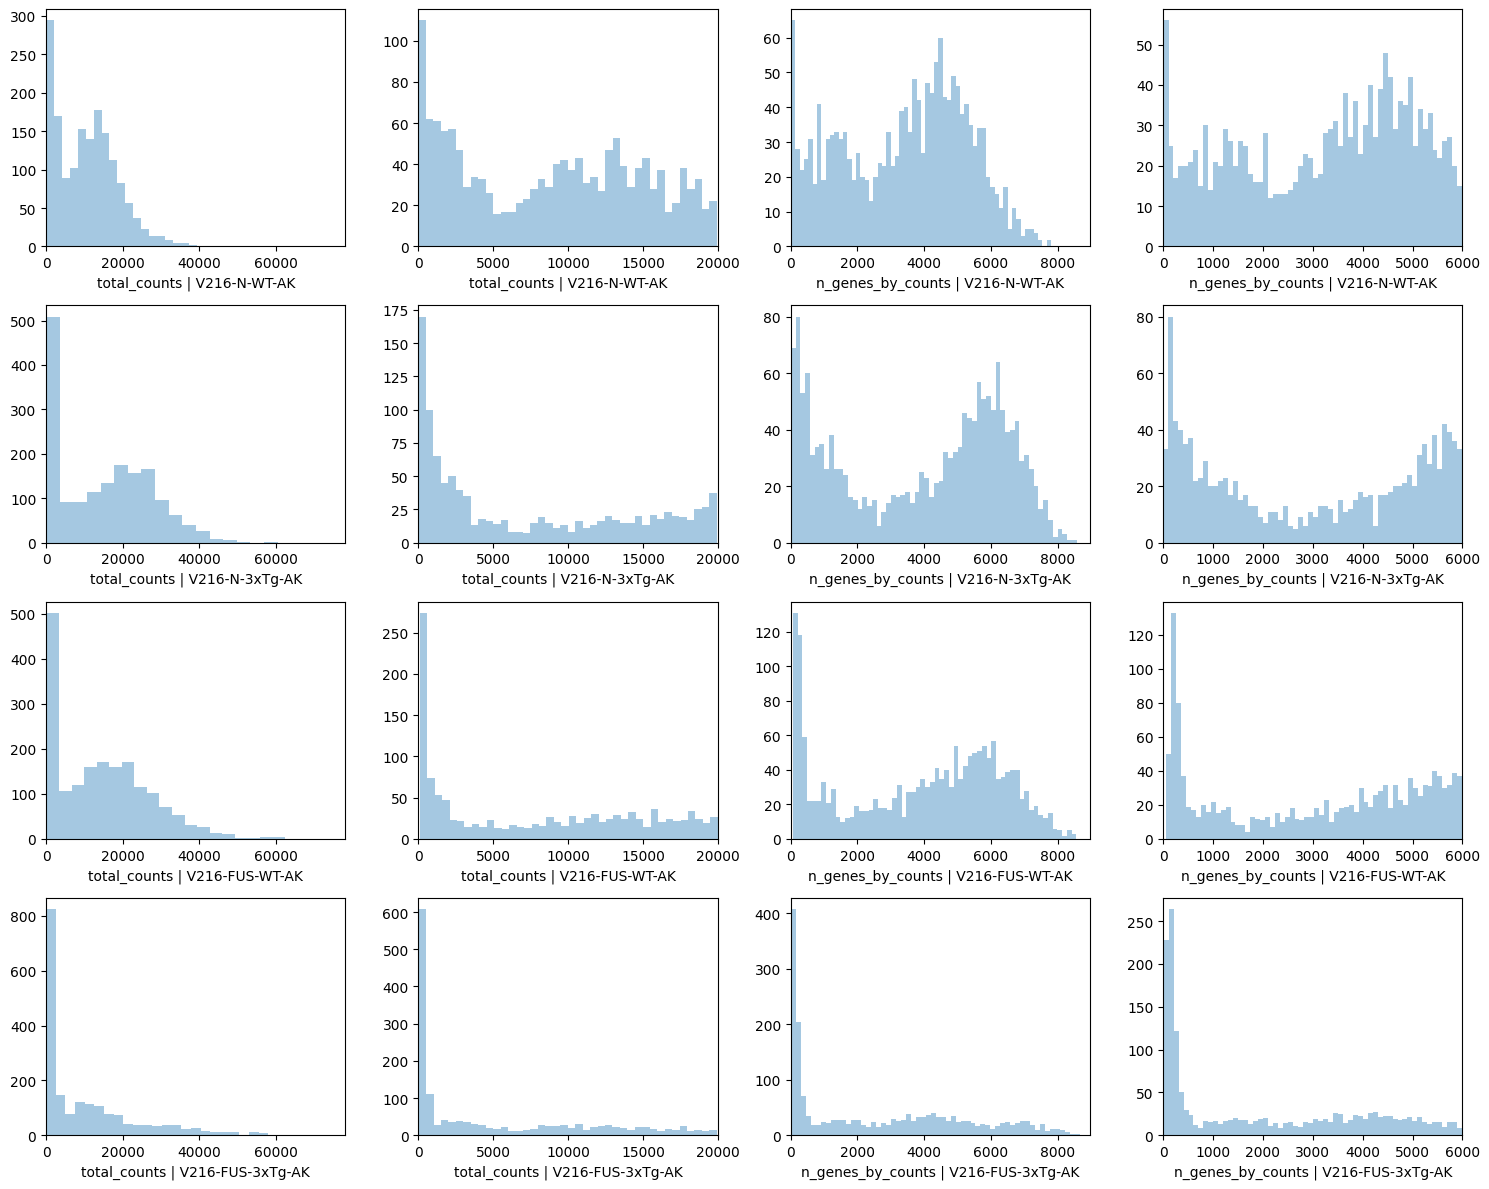

In [8]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)-4))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    sns.distplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.distplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

In [9]:
# load references
adata_ref = sc.read_csv('/media/alina/Backup1/RawData/ReferenceData/Linnarsson_AKCountsMatrix.csv')
meta = pd.read_csv('/media/alina/Backup1/RawData/ReferenceData/Linnarsson_AKMetaMatrix.csv')

In [10]:
adata_ref.obs['Tax']=list(meta['Tax'])
adata_ref.obs['Experiment']=list(meta['Experiment'])

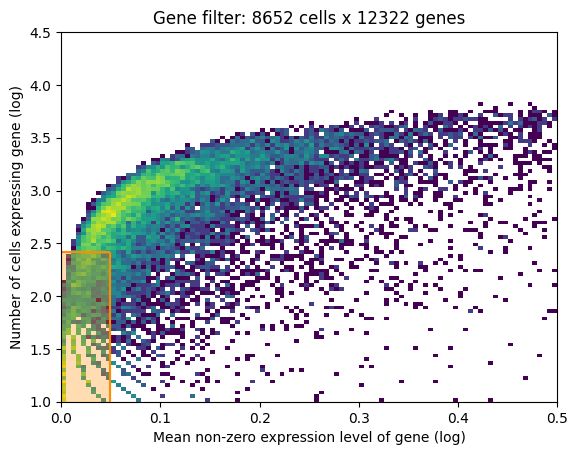

In [11]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()


In [12]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        # cell type, covariate used for constructing signatures
                        labels_key='Tax',
                                                   batch_key="Experiment"
                       )

In [13]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.3.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Experiment',
│   'labels_key': 'Tax',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 12322 │
│         n_cells          │ 8652  │
│         n_batch          │   2   │
│         n_labels         │  46   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Experiment'] │    AKS     │          0          │
│                         │ Linnarsson │          1          │
└─────────────────────────┴────────────┴─────────────────────┘

                                 labels State Registry                                  
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Source Location  ┃                 Categories                  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Tax'] │                      0                      │          0          │
│                  │                      1                      │          1          │
│                  │                      2                      │          2          │
│                  │                      3                      │          3          │
│                  │                      4                      │          4          │
│                  │                      5                      │          5          │
│                  │                      6                      │          6          │
│                  │                 Astrocytes                  │          7          │
│                  │             Cerebellum neurons              │          8          │
│                  │    Cholinergic and monoaminergic neurons    │          9          │
│                  │          Choroid epithelial cells           │         10          │
│                  │        Dentate gyrus granule neurons        │         11          │
│                  │    Dentate gyrus radial glia-like cells     │         12          │
│                  │  Di- and mesencephalon excitatory neurons   │         13          │
│                  │  Di- and mesencephalon inhibitory neurons   │         14          │
│                  │                Enteric glia                 │         15          │
│                  │               Enteric neurons               │         16          │
│                  │               Ependymal cells               │         17          │
│                  │          Glutamatergic neuroblasts          │         18          │
│                  │              Hindbrain neurons              │         19          │
│                  │                  Microglia                  │         20          │
│                  │        Non-glutamatergic neuroblasts        │         21          │
│                  │         Olfactory ensheathing cells         │         22          │
│                  │        Olfactory inhibitory neurons         │         23          │
│                  │       Oligodendrocyte precursor cells       │         24          │
│                  │              Oligodendrocytes               │         25          │
│                  │             Peptidergic neurons             │         26          │
│                  │                  Pericytes                  │         27          │
│                  │  Peripheral sensory neurofilament neurons   │         28          │
│                  │ Peripheral sensory non-peptidergic neurons  │         29          │
│                  │   Peripheral sensory peptidergic neurons    │         30          │
│                  │          Perivascular macrophages           │         31          │
│                  │               Satellite glia                │         32          │
│                  │                Schwann cells                │         33          │
│                  │       Spinal cord excitatory neurons        │         34          │
│                  │       Spinal cord inhibitory neurons        │         35          │
│                  │    Subcommissural organ hypendymal cells    │         36          │
│                  │ Subventricular zone radial glia-like cells  │         37          │
│                  │       Sympathetic cholinergic neurons       │         38          │
│                  │      Sympathetic noradrenergic neurons      │         39          │
│                  │    Telencephalon inhibitory interneurons    │         40       

In [14]:
mod.train(max_epochs=500, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|█| 500/500 [12:41<00:00,  1.52s/it, v_num=1, elbo_train=4.54


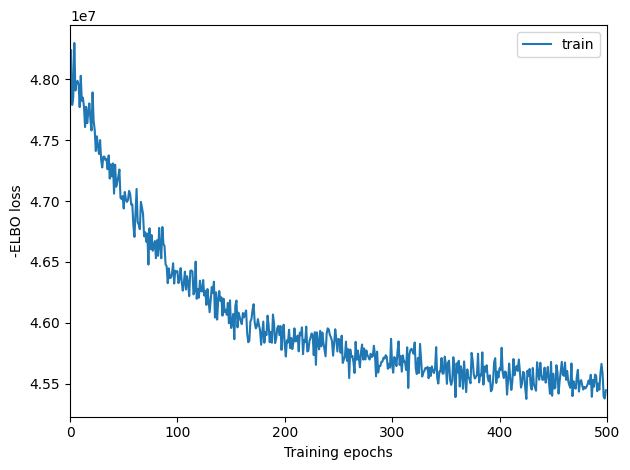

In [15]:
mod.plot_history()

In [16]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

Sampling global variables, sample: 100%|██████| 999/999 [00:47<00:00, 20.89it/s]


In [17]:
ref_run_name = "/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015"
# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

'/media/alina/Backup1/Programming/Cell2LocationOutputs_WithAK_NoIAM_20221015/sc.h5ad'